## Imports

In [47]:
# Initialize global variables
import ml_args
ml_args.init()

# Global imports
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import Image

# Torch library
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Local imports
from load_data import *
from raster_convert import *
from output_display import *
from extract_dataset import *

NB : Please pay attention to the library dependencies and OS requirement indicated in the readme file before running the code

## Build 3D rasters

NB : For ownership reasons, the original dataset is not included in the submission (see readme for description)

In [23]:
ml_dataset_import(ml_args.dataset_low_res, ml_args.raster_low_res, ml_args.width_low_res)
ml_dataset_import(ml_args.dataset_high_res, ml_args.raster_high_res, ml_args.width_high_res)

turing : done
turing : done


'Task completed'

## Load the data

In [24]:
ml_data_low_res = get_ml_data(ml_args.raster_low_res)
ml_data_high_res = get_ml_data(ml_args.raster_high_res)

## Build Torch Tensors from the data

In [32]:
class CloudPointDataset(Dataset):
    ''' Class of cloudpoint data that will be usable by Pytorch '''

    def __init__(self, thin_dataset, thick_dataset, train, transform=None):
        """
        Args:
            mat_file (string): Path to the mat file with the data
            train (boolean): Is it the training data or the test data
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.X = thin_dataset
        self.Y = thick_dataset
        self.X = np.asarray(self.X).astype(float)
        self.Y = np.asarray(self.Y).astype(float)
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(self.X, self.Y, test_size=0.01, random_state=1)
        self.Xtrain, self.Xtest = Xtrain, Xtest
        self.Ytrain, self.Ytest = Ytrain, Ytest
        self.train = train
        self.transform = transform

    def __len__(self):
        if self.train:
            return (self.Xtrain.shape[0])
        else:
            return (self.Xtest.shape[0])

    def __getitem__(self, idx):
        
        if self.train:
            sample = {'image': self.Xtrain[idx,:], 'label': self.Ytrain[idx,:]}
        else:
            sample = {'image': self.Xtest[idx,:], 'label': self.Ytest[idx,:]}
            
        if self.transform:
            sample = self.transform(sample)

        return sample

In [26]:
class ToTensor(object):
    ''' Convert ndarrays in sample to Tensors. '''

    def __call__(self, sample):
        raster, label = sample['image'], sample['label']
        raster = torch.from_numpy(raster).float()
        raster = raster.expand(1, ml_args.width_low_res, ml_args.width_low_res, ml_args.width_low_res)
        return {'image': raster, 'label': label}

In [34]:
# Define the trainset and testset and put them in the form of a torch tensor
trainset = CloudPointDataset(ml_data_low_res, ml_data_high_res, train=True, transform = ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 10, shuffle=False, num_workers=0)

testset = CloudPointDataset(ml_data_low_res, ml_data_high_res, train=False, transform=ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size = 10, shuffle=False, num_workers=0)

## Define the model & CNN architecture

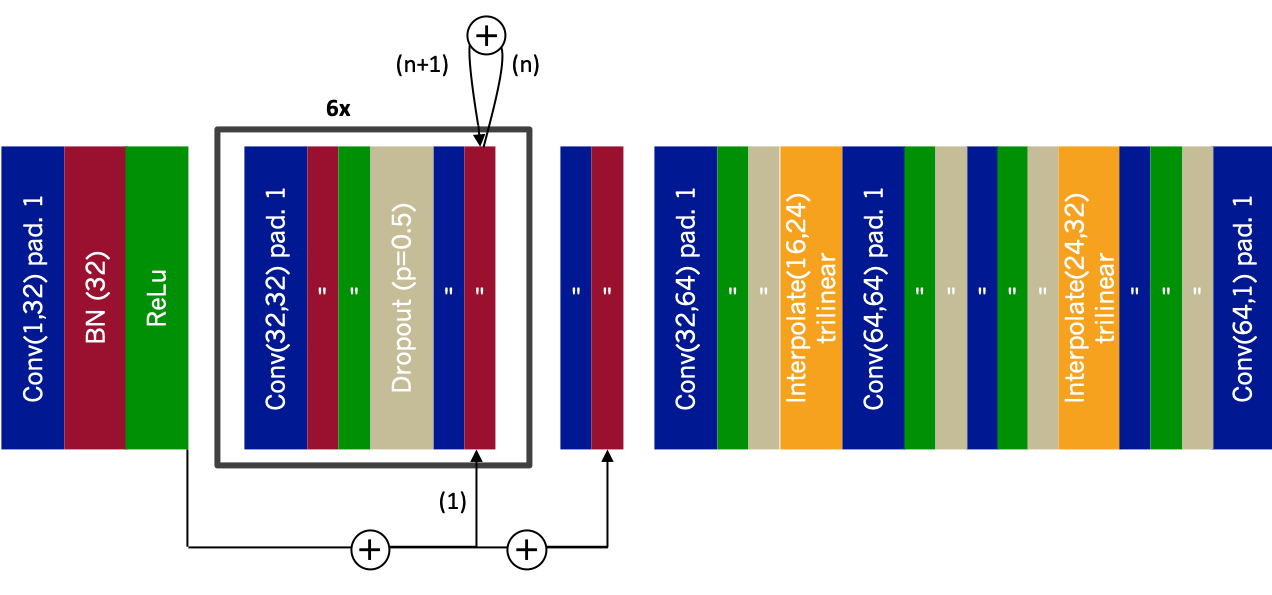

In [28]:
Image(filename='img/cnn_model.png', width=600)

In [29]:
class Net(nn.Module):
    def __init__(self):
        ''' Define the functions that are to be used in the CNN '''
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, 3, padding = 1, stride = 1)
        self.conv2 = nn.Conv3d(32, 32, 3, padding = 1, stride = 1)
        self.conv3 = nn.Conv3d(32, 64, 3, padding = 1, stride = 1)
        self.conv4 = nn.Conv3d(64, 64, 3, padding = 1, stride = 1)
        self.conv5 = nn.Conv3d(64, 1, 3, padding = 1, stride = 1)
        
        self.BN = nn.BatchNorm3d(num_features = 32)
        self.dropout = nn.Dropout3d()
        
        # Padding/unpadding operations
        self.replication_padding = nn.ReplicationPad3d(2)
        self.zero_padding = nn.ConstantPad3d(2, 0)
        self.depadding = nn.ReplicationPad3d(-4)
        
    def forward(self, x):
        ''' Define the architecture of the CNN '''
        
        # Empty storage vector
        x_ = []
        # x = self.replication_padding(x)
        # x = self.zero_padding(x)
        
        # Augment the number of layers from 1 to 32
        x = self.conv1(x)
        x = self.BN(x)
        x = F.relu(x)
        x_.append(x)
        
        # 6 residual blocks (core CNN)
        for i in range(6):
            x = self.conv2(x)
            x = self.BN(x)
            x = F.relu(x)
            x = self.dropout(x)
            x = self.conv2(x)
            x = self.BN(x)
            x = x + x_[-1]
            x_.append(x)
        
        x = self.conv2(x)
        x = self.BN(x)
        x = x + x_[0]
        
        # Augment the number of layers from 32 to 64
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Two-step interpolation to the higher resolution
        x = nn.functional.interpolate(x, size = (24, 24, 24), mode='trilinear')
        # x = nn.functional.interpolate(x, size = (30, 30, 30), mode='trilinear')
        x = self.conv4(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = F.relu(x) 
        x = self.dropout(x)
        x = nn.functional.interpolate(x, size = (32, 32, 32), mode='trilinear')
        # x = nn.functional.interpolate(x, size = (40, 40, 40), mode='trilinear')
        x = self.conv4(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # x = self.depadding(x)
        
        # Reduce the number of layers again from 64 to 1
        x = self.conv5(x)        
        
        return x

model = Net()

In [30]:
# Define the criterion (loss function) and the optimizer (here : stochastic gradient descent)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.8)

# Train the model

In [ ]:
y_hat, y, x = [], [], []

for epoch in range(3):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        images, labels = data['image'], data['label'].float()
        
        # wrap them in Variable
        images, labels = Variable(images), Variable(labels)

        # clear the gradients of the variables
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        outputs = np.squeeze(outputs, axis=0)
        labels = np.squeeze(labels, axis=0)
        
        #outputs = np.expand_dims(outputs, axis=1)
        y_hat.append(outputs)
        x.append(images)
        y.append(labels)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]

        # print every mini-batches
        if i+1 == 7:
            print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss))
            
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, './model/model_epoch_' + str(epoch))

print('Finished Training')

### Train outputs description

In [ ]:
print('Outputs dimensions:', len(outputs), len(outputs[0]), len(outputs[0][0]), len(outputs[0][0][0]))

In [ ]:
print('Low resolution data dimensions:', len(x), len(x[0]), 
      len(x[0][0]), len(x[0][0][0]), len(x[0][0][0][0]), len(x[0][0][0][0][0]))

In [ ]:
print('High resolution data dimensions:', len(y), len(y[0]), 
      len(y[0][0]), len(y[0][0][0]), len(y[0][0][0][0]))

In [ ]:
print('Super-resolution data dimensions:', len(y_hat), len(y_hat[0]),
      len(y_hat[0][0]), len(y_hat[0][0][0]), len(y_hat[0][0][0][0]))

## Apply it to the test set

In [ ]:
y_hat_, y_, x_ = [], [], []
model.eval()

with torch.no_grad():

    for i, data in enumerate(testloader, 0):

        images, labels = data['image'], data['label'].float()
        images, labels = Variable(images), Variable(labels)
    
        outputs = model(images)
        outputs = np.squeeze(outputs, axis=1)
        
        y_hat_.append(outputs)
        x_.append(images)
        y_.append(labels)

# Or Load the pre-trained model (to evaluate it on a test set)
NB : In that option, you won't be able to see the test set results !

### Test outputs description

In [36]:
print('Outputs dimensions:', len(outputs), len(outputs[0]), len(outputs[0][0]), len(outputs[0][0][0]))

Outputs dimensions: 6 32 32 32


In [37]:
print('Low resolution data dimensions:', len(x_), len(x_[0]), 
      len(x_[0][0]), len(x_[0][0][0]), len(x_[0][0][0][0]), len(x_[0][0][0][0][0]))

Low resolution data dimensions: 14 10 1 16 16 16


In [38]:
print('High resolution data dimensions:', len(y_), len(y_[0]), 
      len(y_[0][0]), len(y_[0][0][0]), len(y_[0][0][0][0]))

High resolution data dimensions: 14 10 32 32 32


In [39]:
print('Super-resolution data dimensions:', len(y_hat_), len(y_hat_[0]),
      len(y_hat_[0][0]), len(y_hat_[0][0][0]), len(y_hat_[0][0][0][0]))

Super-resolution data dimensions: 14 10 32 32 32


# Print the output

In [40]:
%matplotlib
'''#%matplotlib qt # comment if you want to plot inline'''
%matplotlib inline 
# comment if you want to plot in interactive 3D

Using matplotlib backend: MacOSX


Pick the batch indice n and the raster indice m corresponding to the raster you want to see
(NB : learning is random => ordering will change each time you train the model)

In [ ]:
n = len(y) - 1 # any number between 0 and len(y) = # of batch
m = 0 # any number between 0 and batch size

In [ ]:
print_3D(x, n, m, mode = 'x')

In [ ]:
print_3D(y, n, m, mode = 'y')

In [ ]:
print_3D_pred(y_hat, x, n, m, advanced_mode = False)

In [ ]:
# dilatation algorithm enabled
print_3D_pred(y_hat, x, n, m, advanced_mode = True)

Pick the batch indice n and the raster indice m corresponding to the raster you want to see
(NB : learning is random => ordering will change each time you train the model)

In [58]:
n = len(y_) - 1  # any number between 0 and len(y_) = # of batch
m = 1 # any number between 0 and batch size

True

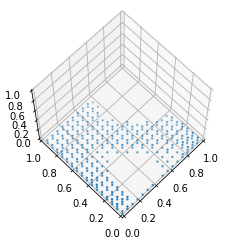

In [59]:
print_3D(x_, n, m, mode = 'x')

True

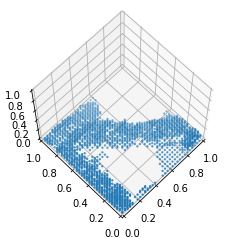

In [64]:
print_3D(y_, n, m, mode = 'y')

0.0 0.008911133 0.0 1.0 0.0


True

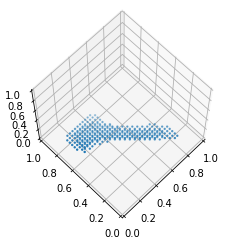

In [73]:
print_3D_pred(y_hat_, x_, n, m, advanced_mode = False)

0.0 0.008911133 0.0 1.0 0.0


True

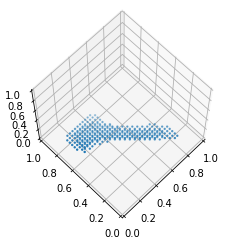

In [74]:
# dilatation algorithm enabled
print_3D_pred(y_hat_, x_, n, m, advanced_mode = True)